!pip install pandas
!pip install backtesting 
!pip install numpy matplotlib
!pip install pandas-ta

In [3]:
# Paso 2: Importar las Librerías Necesarias
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
# from backtesting.test import GOOG

pd.options.mode.chained_assignment = None


In [ ]:
#### import data as satoshi

In [4]:
# importar data 
datapath = '../data/BTCUSDT5m.csv'
data = pd.read_csv(datapath, parse_dates=True, index_col=0, )
data = (data / 1e6).assign(Volume=data.Volume * 1e6)  # μBTC OHLC prices

data.head(1)


,DateStamp,Open,High,Low,Close,Volume
Date,,,,,,
2023-05-01,1682899.2,0.029233,0.029298,0.029216,0.029297,469948630.0


#### Indicadores

###### Indicadores pandas series

In [6]:
# Indicators pandas Series

def SMA(df, n):
    """Simple moving average"""
    return pd.Series(df).rolling(n).mean()

# Calcular la Media Móvil Exponencial (EMA)
def EMA(df, n):
    """Simple moving average"""
    return pd.Series(df).ewm(span=n, adjust=False).mean()


def RSI(df, n):
    """Relative strength index"""
    # Approximate; good enough
    gain = pd.Series(df).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)

def BBANDS(df, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (df.High + df.Low + df.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower

<Axes: xlabel='Date'>

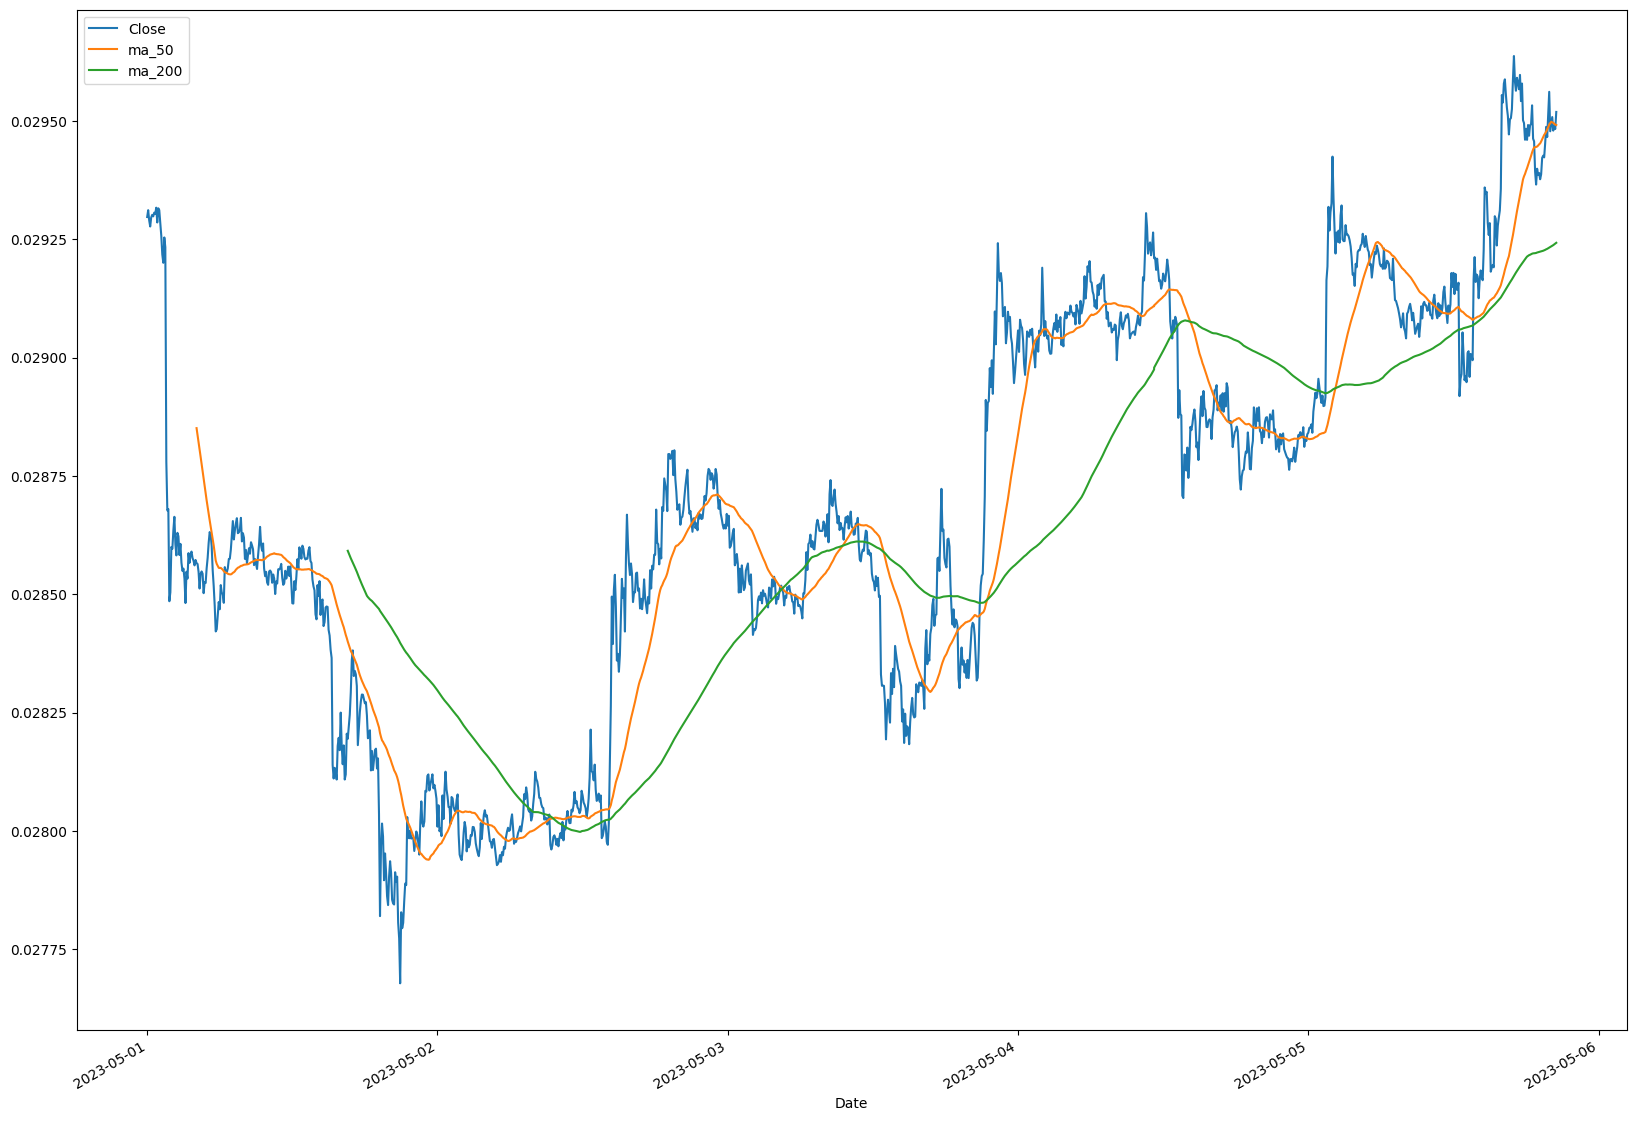

In [7]:
# ma_200 and ma_50

ma_50 = SMA(data["Close"], 50)
ma_200 = SMA(data["Close"], 200)


ptl = data[["Close"]]  

#ptl.insert(0,"ma_501", ma_50) 
ptl["ma_50"] = ma_50
ptl["ma_200"] = ma_200
 
ptl[:1400].plot(figsize=(20,15 ))



###### Pandas_ta

In [ ]:
# !pip install pandas_ta --force-reinstall
!pip install TA-Lib
!pip install -U git+https://github.com/twopirllc/pandas-ta --force-reinstall
# !pip install -U git+https://github.com/twopirllc/pandas-ta.git@development
#!pip install numpy==1.19
#!pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.5/368.5 kB 7.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for TA-Lib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      <string>:75: UserWarning: Cannot find ta-lib library, installation may fail.
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-310
      creating build/lib.linux-x86_64-cpython-310/talib
      copying talib/abstract.py -> build/lib.linux-x86_64-cpython-310/talib
      copying talib/__init__.py -> build/lib.linux-x86_64-cpython-310/talib
      copying talib/stream.py -> build/lib.linux-x86_64-cpython-310/talib
      copying talib/deprecated.py -> build/lib.linux-x86_64-cpython-310/talib
      running build_ext
      buil

In [34]:
!pip list

Package                   Version
------------------------- --------------
aiodns                    3.2.0
aiohttp                   3.9.5
aiosignal                 1.3.1
anyio                     4.4.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
async-timeout             4.0.3
attrs                     23.2.0
Babel                     2.15.0
Backtesting               0.3.3
beautifulsoup4            4.12.3
bleach                    6.1.0
bokeh                     3.4.1
ccxt                      4.3.46
certifi                   2024.2.2
cffi                      1.16.0
charset-normalizer        3.3.2
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.2.1
cryptography              42.0.8
cycler                    0.12.1
debugpy                   1.8.1
decorator                 5.1.1
defusedxml                0.7.1
exceptiongroup   

In [41]:
# Indicators pandas_ta

import pandas as pd
import pandas_ta as ta
# from numpy import NaN as npNaN

ImportError: cannot import name 'NaN' from 'numpy' (/home/codespace/.local/lib/python3.10/site-packages/numpy/__init__.py)

In [24]:
# Version 2
def SMA(df, n):
    """Simple moving average"""
    return pd.Series(pd.Series.rolling(df["Close"], n).mean(), name="MA_" + str(n))

def EMA(df, n):
    return pd.Series(pd.Series.ewm(df["Close"], span=n, min_periods=n-1, adjust=False).mean(), name="EMA_" + str(n))

## Estrategias

### Mean Reversion // quemada!

In [12]:

class MeanReversionStrategy(Strategy):
    slPercent = .99
    # maL = 20
    maTb = 5
    maBb = 25

    def init(self):
        # Inicializa las Bandas de Bollinger
        price = self.data.Close
      
        # self.ma = self.I(SMA, price, self.maL)  # Media Móvil Simple de 20 períodos
        self.upper_band = self.I(SMA, price, self.maTb)  # Media Móvil Simple de 20 períodos
        self.lower_band = self.I(SMA, price, self.maBb)  # Media Móvil Simple de 20 períodos


    def next(self):
        price = self.data.Close[-1]

        # Señal de compra: el precio cruza por debajo de la banda inferior
        if crossover(self.lower_band, price):
            self.buy(sl = price * self.slPercent)

        # Señal de venta: el precio cruza por encima de la banda superior
        elif crossover(price, self.upper_band):
            self.buy(sl = price * self.slPercent)



###### Optimizacion

In [19]:
bt = Backtest(data, MeanReversionStrategy, cash=100, commission=.002)

stats, heat = bt.optimize(
    #slPercent=[.99,.98,.97,.96,.95,.94],
    
    maTb=range(20, 40),
    maBb=range(5, 20),
    maximize = "Return [%]",
    return_heatmap=True
    )

stats


Start                     2023-05-01 00:00:00
End                       2024-06-17 02:30:00
Duration                    413 days 02:30:00
Exposure Time [%]                   99.143534
Equity Final [$]                   228.637236
Equity Peak [$]                     254.02382
Return [%]                         128.637236
Buy & Hold Return [%]              126.408849
Return (Ann.) [%]                  109.532647
Volatility (Ann.) [%]              102.344791
Sharpe Ratio                         1.070232
Sortino Ratio                        3.820008
Calmar Ratio                         4.785032
Max. Drawdown [%]                  -22.890681
Avg. Drawdown [%]                   -1.404852
Max. Drawdown Duration      102 days 01:00:00
Avg. Drawdown Duration        1 days 21:33:00
# Trades                                   13
Win Rate [%]                         7.692308
Best Trade [%]                     164.209183
Worst Trade [%]                     -1.197643
Avg. Trade [%]                    

In [14]:
stats["_strategy"]

<Strategy MeanReversionStrategy(maTb=38,maBb=18)>

###### Final

In [18]:

class MeanReversionStrategyOptimized(MeanReversionStrategy):
    maTb=38
    maBb=18
    
bt = Backtest(data, MeanReversionStrategyOptimized, cash=100, commission=.002)
stats = bt.run()
stats

Start                     2023-05-01 00:00:00
End                       2024-06-17 02:30:00
Duration                    413 days 02:30:00
Exposure Time [%]                   98.825298
Equity Final [$]                    226.59091
Equity Peak [$]                    251.749382
Return [%]                          126.59091
Buy & Hold Return [%]              126.408849
Return (Ann.) [%]                  105.682279
Volatility (Ann.) [%]               99.896094
Sharpe Ratio                         1.057922
Sortino Ratio                        3.684059
Calmar Ratio                         4.616974
Max. Drawdown [%]                  -22.889945
Avg. Drawdown [%]                   -1.395902
Max. Drawdown Duration      102 days 01:00:00
Avg. Drawdown Duration        1 days 21:31:00
# Trades                                   14
Win Rate [%]                         7.142857
Best Trade [%]                      165.03375
Worst Trade [%]                     -1.197643
Avg. Trade [%]                    

### RSI cross strategy

In [15]:
# RSI cross strategy
class RSIcross(Strategy):
  rsi_period = 17 
  slPercent = 0.99
 
  def init(self):
    price = self.data.Close
    self.rsi = self.I(RSI, price ,self.rsi_period)


  def next(self):
    price = self.data.Close[-1]

    if self.rsi[-1] < 30:
      self.position.close()

    if self.position.is_long:
      return

    self.buy(sl = price * self.slPercent)



In [16]:
bt = Backtest(data[:10000],RSIcross,cash = 40)
stats = bt.run()
stats


Start                     2023-05-01 00:00:00
End                       2023-06-04 16:30:00
Duration                     34 days 16:30:00
Exposure Time [%]                       99.97
Equity Final [$]                    36.846565
Equity Peak [$]                     40.869775
Return [%]                          -7.883588
Buy & Hold Return [%]                -7.20623
Return (Ann.) [%]                  -35.975377
Volatility (Ann.) [%]               20.404506
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -13.306695
Avg. Drawdown [%]                   -2.543949
Max. Drawdown Duration       29 days 15:55:00
Avg. Drawdown Duration        3 days 11:13:00
# Trades                                  136
Win Rate [%]                        30.147059
Best Trade [%]                       4.620728
Worst Trade [%]                     -1.000038
Avg. Trade [%]                    

In [13]:
# momentun

import pandas as pd
from backtesting import Backtest, Strategy
from backtesting.lib import crossover



# Identificar patrones de velas (ejemplo: Engulfing Pattern)
def is_bullish_engulfing(data):
    return (data['Open'].shift(1) > data['Close'].shift(1)) & (data['Close'] > data['Open']) & (data['Close'] > data['Open'].shift(1)) & (data['Open'] < data['Close'].shift(1))

def is_bearish_engulfing(data):
    return (data['Open'].shift(1) < data['Close'].shift(1)) & (data['Close'] < data['Open']) & (data['Close'] < data['Open'].shift(1)) & (data['Open'] > data['Close'].shift(1))


class MomentumTradingStrategy(Strategy):
    def init(self):
        # Inicializar indicadores
        self.sma_short = self.I(SMA, self.data.Close, 20)
        self.sma_long = self.I(SMA, self.data.Close, 50)
        self.rsi = self.I(RSI, self.data.Close, 14)
        # self.bullish_engulfing = self.I(is_bullish_engulfing, self.data)
        # self.bearish_engulfing = self.I(is_bearish_engulfing, self.data)

    def next(self):
        if crossover(self.sma_short, self.sma_long) and self.rsi[-1] > 50 :#and self.bullish_engulfing[-1]:
            self.buy()
        elif crossover(self.sma_long, self.sma_short) and self.rsi[-1] < 50:# and self.bearish_engulfing[-1]:
            self.sell()

# Ejecutar el backtest
bt = Backtest(data, MomentumTradingStrategy, cash=10000, commission=.002)
stats = bt.run()
stats



ALERTA [0.07152111 0.07144365 0.07138    ... 0.06659747 0.06660002 0.06662862] 14


Start                     2024-03-15 00:00:00
End                       2024-06-16 13:05:00
Duration                     93 days 13:05:00
Exposure Time [%]                   99.592109
Equity Final [$]                  9577.804032
Equity Peak [$]                  11561.037835
Return [%]                           -4.22196
Buy & Hold Return [%]               -6.840624
Return (Ann.) [%]                    4.261955
Volatility (Ann.) [%]               78.714426
Sharpe Ratio                         0.054145
Sortino Ratio                        0.088049
Calmar Ratio                         0.160761
Max. Drawdown [%]                    -26.5112
Avg. Drawdown [%]                   -3.004276
Max. Drawdown Duration       45 days 19:55:00
Avg. Drawdown Duration        2 days 15:50:00
# Trades                                   12
Win Rate [%]                        33.333333
Best Trade [%]                      12.816323
Worst Trade [%]                     -16.48854
Avg. Trade [%]                    

### system strategy

In [9]:

# https://github.com/SharmaVidhiHaresh/Backtesting-Trading-Strategies-with-Python/

from backtesting.lib import resample_apply


class SystemStrategy(Strategy):
    d_rsi = 30  # Daily RSI lookback periods
    w_rsi = 30  # Weekly
    level = 70
    sl=.92
    
    def init(self):
        # Compute moving averages the strategy demands
        self.ma10 = self.I(SMA, self.data.Close, 10)
        self.ma20 = self.I(SMA, self.data.Close, 20)
        self.ma50 = self.I(SMA, self.data.Close, 50)
        self.ma100 = self.I(SMA, self.data.Close, 100)
        
        # Compute daily RSI(30)
        self.daily_rsi = self.I(RSI, self.data.Close, self.d_rsi)
        
        # To construct weekly RSI, we can use `resample_apply()`
        # helper function from the library
        self.weekly_rsi = resample_apply(
            'W-FRI', RSI, self.data.Close, self.w_rsi)
        
        
    def next(self):
        price = self.data.Close[-1]
        
        # If we don't already have a position, and
        # if all conditions are satisfied, enter long.
        if (not self.position and
            self.daily_rsi[-1] > self.level and
            #self.weekly_rsi[-1] > self.level and
            #self.weekly_rsi[-1] > self.daily_rsi[-1] and
            self.ma10[-1] > self.ma20[-1] > self.ma50[-1] > self.ma100[-1] and
            price > self.ma10[-1]):
            
            # Buy at market price on next open, but do
            # set 8% fixed stop loss.
            self.buy(sl=self.sl * price)
        
        # If the price closes 2% or more below 10-day MA
        # close the position, if any.
        elif price < .98 * self.ma10[-1]:
            self.position.close()

bt = Backtest(data, SystemStrategy, cash=10000, commission=.002)
stats = bt.run()
stats

ALERTA [0.02929715 0.02931159 0.02929003 ... 0.06633001 0.06626999 0.06633134] 30
ALERTA Date
2023-05-05    0.029506
2023-05-12    0.026795
2023-05-19    0.026880
2023-05-26    0.026706
2023-06-02    0.027243
2023-06-09    0.026478
2023-06-16    0.026345
2023-06-23    0.030689
2023-06-30    0.030472
2023-07-07    0.030345
2023-07-14    0.030312
2023-07-21    0.029902
2023-07-28    0.029314
2023-08-04    0.029114
2023-08-11    0.029426
2023-08-18    0.026054
2023-08-25    0.026060
2023-09-01    0.025805
2023-09-08    0.025910
2023-09-15    0.026600
2023-09-22    0.026580
2023-09-29    0.026907
2023-10-06    0.027931
2023-10-13    0.026862
2023-10-20    0.029669
2023-10-27    0.033892
2023-11-03    0.034717
2023-11-10    0.037302
2023-11-17    0.036614
2023-11-24    0.037714
2023-12-01    0.038683
2023-12-08    0.044171
2023-12-15    0.041940
2023-12-22    0.043969
2023-12-29    0.042067
2024-01-05    0.044145
2024-01-12    0.042783
2024-01-19    0.041659
2024-01-26    0.041824
2024-02-0

RuntimeError: Indicator "RSI(C[W-FRI],30)" errored with exception: cannot reindex on an axis with duplicate labels